Dataset size after outlier removal:  (327, 13)
Regression R^2 score:  0.6631428613568626
Lasso R^2 score:  0.6704387123428823
Ridge R^2 score:  0.6823824571165065
Forest R^2 score:  0.7560819827136821
SVR R^2 score:  0.7698764189642151
KNR R^2 score:  0.7363028322531915
XBG R^2 score:  0.7479396091201143


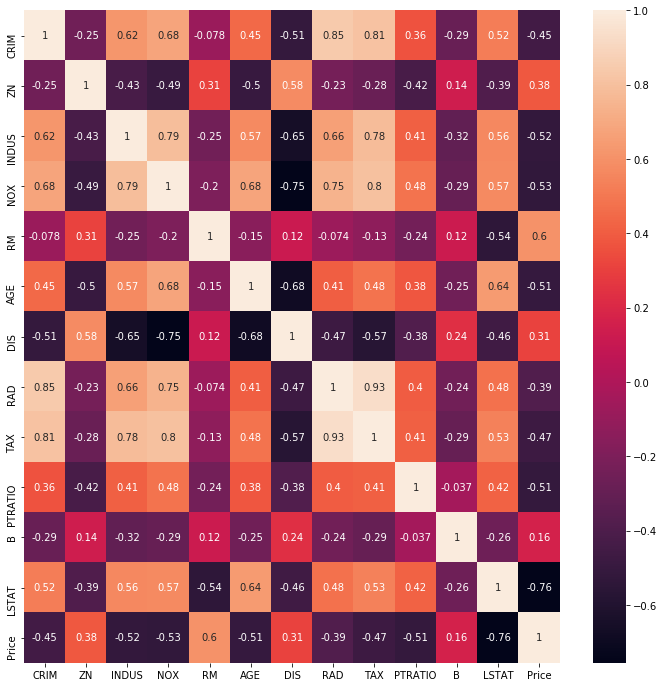

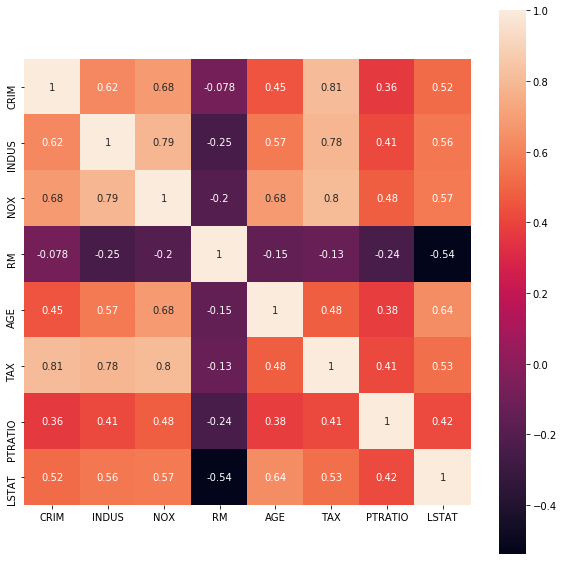

In [20]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline 
import seaborn as sb
from scipy.stats import zscore


#Load the Boston data set
from sklearn.datasets import load_boston
HousingData = load_boston()
DF = pd.DataFrame(HousingData.data, columns=HousingData.feature_names)
DF['Price'] = HousingData.target
DF = DF.drop('CHAS', axis=1) # its a binary variable that is not needed for linear regression.

# keep anything that is less than two standard deviations from the mean
Z = np.abs(zscore(DF))
outlier_index = (Z < 2).all(axis=1)
DF = DF[outlier_index].reset_index(drop=True)

print('Dataset size after outlier removal: ', DF.shape)

# mean normalization
from sklearn.preprocessing import scale
DF_scaled = pd.DataFrame(scale(DF), columns=DF.columns)

# Reshuffled to avoid autocorrelation
DF = DF.sample(len(DF), replace=False)
DF_scaled = DF_scaled.loc[DF.index]

# heat map to see which features correlated with each other
plt.figure(figsize=(12,12))
sb.heatmap(pd.DataFrame(np.corrcoef(DF_scaled.T)), annot=True,
          xticklabels=DF.columns, yticklabels=DF.columns)


#Select features that are highly correlated with price
features = np.array(['CRIM','INDUS','NOX','RM','AGE','TAX','PTRATIO','LSTAT'])

#heatmap of selected features 
plt.figure(figsize=(10,10))
sb.heatmap(np.corrcoef(DF_scaled[features].T), annot=True, square=True, xticklabels=features, yticklabels=features)

#--------------------------------------------------------------------------------------------------------------------

from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(DF_scaled, test_size=0.3)
# Loading packages for regression
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Lasso,Ridge 
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor as KNR
import xgboost as XGB


#Instantiate

reg = LR()
lasso = Lasso(alpha = .02)
ridge = Ridge(alpha = 50)
forest = RF(max_depth = 20, n_estimators = 100)
svr = SVR(C = .6)
knn = KNR(n_neighbors = 5)
boost = XGB.XGBRegressor(max_depth = 4, alpha = 2, learning_rate = .2)

#Fit

reg.fit(df_train[features], df_train.Price)
lasso.fit(df_train[features], df_train.Price)
ridge.fit(df_train[features], df_train.Price)
forest.fit(df_train[features], df_train.Price)
svr.fit(df_train[features], df_train.Price)
knn.fit(df_train[features], df_train.Price)
boost.fit(df_train[features], df_train.Price)

#Test accuracy
print('Regression R^2 score: ', reg.score(df_test[features], df_test.Price))
print('Lasso R^2 score: ', lasso.score(df_test[features], df_test.Price))
print('Ridge R^2 score: ', ridge.score(df_test[features], df_test.Price))
print('Forest R^2 score: ', forest.score(df_test[features], df_test.Price))
print('SVR R^2 score: ', svr.score(df_test[features], df_test.Price))
print('KNR R^2 score: ', knn.score(df_test[features], df_test.Price))
print('XBG R^2 score: ', boost.score(df_test[features], df_test.Price))

#-------------------------------------------------------------------------------

# K-Fold Cross Validation with 10 folds
from sklearn.model_selection import KFold
n_splits = 10
KF = KFold(n_splits = n_splits)
KF.get_n_splits(DF_scaled)

Scores = []

for ind_train, ind_test in KF.split(DF_scaled):
    train = DF_scaled.loc[ind_train, features]
    test = DF_scaled.loc[ind_test, features]
    #Instantiate
    
    # Parameters are hard coded after optimization
    reg = LR() # standard linear regression
    lasso = Lasso(alpha = .02) #lasso shrinkage
    ridge = Ridge(alpha = 50) # ridge shrinkage
    forest = RF(max_depth = 20, n_estimators = 100) # random forest regressor
    svr = SVR(C = .6) # support vector regressor
    knn = KNR(n_neighbors = 5) # k nearest neighbor regressor
    boost = XGB.XGBRegressor(objective = 'reg:squarederror', colsample_bytree = .5, max_depth = 4, 
                             alpha = 2, learning_rate = .2) # extreme gradient boost regressor

    #Fit

    reg.fit(train, DF_scaled.loc[ind_train, 'Price'])
    lasso.fit(train, DF_scaled.loc[ind_train, 'Price'])
    ridge.fit(train, DF_scaled.loc[ind_train, 'Price'])
    forest.fit(train, DF_scaled.loc[ind_train, 'Price'])
    svr.fit(train, DF_scaled.loc[ind_train, 'Price'])
    knn.fit(train, DF_scaled.loc[ind_train, 'Price'])
    boost.fit(train, DF_scaled.loc[ind_train, 'Price'])

    #Test accuracy
    reg_score = reg.score(test, DF_scaled.loc[ind_test, 'Price'])
    lasso_score = lasso.score(test, DF_scaled.loc[ind_test, 'Price'])
    ridge_score = ridge.score(test, DF_scaled.loc[ind_test, 'Price'])
    forest_score = forest.score(test, DF_scaled.loc[ind_test, 'Price'])
    svr_score = svr.score(test, DF_scaled.loc[ind_test, 'Price'])
    knn_score = knn.score(test, DF_scaled.loc[ind_test, 'Price'])
    boost_score = boost.score(test, DF_scaled.loc[ind_test, 'Price'])

    
    Scores.append([reg_score, lasso_score, ridge_score, forest_score, svr_score, knn_score, boost_score])



# Conclusion: KFold Cross validation best scores go to SVR and Random Forest
